In [1]:
#import packages
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import time as timee
#%qtconsole 

def run_DGP(periods,dimensions, lag = False):

    ##Data Generating Process######
    np.random.seed(1337)# this is the only part of the whole code which is stochastic

    n_dim = dimensions #INPUT # number of dimensions #

    t=np.array(periods) #INPUT #500  


    #try out different scales
    Q=np.array(0.001) #0.001
    R=np.array(0.01) #0.01
    Q_test = 0.001  
    R_test = 0.01


    #generate white noise series
    e1 = np.random.normal(0,1,[t, n_dim])
    #e1 = e1*Q
    e1 = e1*Q

    e2 = np.random.normal(0,1,[t, n_dim])
    e2 = e2*R

    e3 = np.random.normal(0,1,[t, n_dim])
    e3 = e3*Q_test

    #generate containers
    Beta = np.zeros(shape=[t, n_dim]) 
    Y= np.zeros(shape=[t, n_dim])


    #generate  X as N-(3,1) process
    X = np.random.normal(3,1,size=[t, n_dim])

    #generate state variable beta as random walk process, and Y as a function of this.

    
    # For lagg 2 
    if(lag) :
        for i in np.arange(0,n_dim):
            for j in np.arange(2,t).reshape(-1):
                Beta[j][i] = Beta[j-1][i] + e2[j][i]
                Y[j][i] = X[j][i]*Beta[j][i] + X[j-1][i]*Beta[j-1][i] +  X[j-2][i]*Beta[j-2][i] + e1[j][i] +e3[j][i]  #+e4[j][n_dim-1]
    else:
        for i in np.arange(0,n_dim):
            for j in np.arange(1,t).reshape(-1):
                Beta[j][i] = Beta[j-1][i] + e2[j][i]
                Y[j][i] = X[j][i]*Beta[j][i] + e1[j][i] +e3[j][i]  #+e4[j][n_dim-1]
            
    X_raw = X  
    Y_raw = Y

    return(X_raw, Y_raw, Beta)

In [2]:
def get_priors(n_dim, K ):
    # n_dim x n_dim 
    sigma_bar = np.identity(n_dim)*0.05
    
    # Random prior initialization. Not sure if this need to be well informed initialisation or random.
    Q_0 = np.eye(n_dim*K)*1.01
    beta_0 = np.eye(n_dim*K,1)*0.06
    return sigma_bar, Q_0, beta_0

# creating x = I ⊗ X, Xt = [y t−1 0 ,...,y t−l ,1]
def get_x(time, lag_length, K, Y, X, n_dim):
    X = np.concatenate((X, np.ones(shape=[time_dim, 1])), axis=1)
    return X

def tvp_da(sigma_bar, Q_0, beta_0, X, Y, time, K, n_dim):
    qK = n_dim*K
    beta = np.zeros([time,qK,1])
    beta[lag_length] = beta_0
    
    Q_prev = Q_0
    Y_hat = np.zeros(shape=[time, n_dim])
    avg = 0
    for t in range(lag_length+1,time):
        start1 = timee.time()
        x = np.kron(np.identity(n_dim),X[t])
        kalman_gain = (Q_prev @ x.T) @ np.linalg.inv(x @ Q_prev @ x.T + sigma_bar)
#         kalman_gain = (Q_prev @ x[t].T) @ np.linalg.inv(x[t] @ Q_prev @ x[t].T + sigma_bar)
        Y_new = np.reshape(Y[t],(n_dim,1))
#         y_hat = (x[t] @ beta[t-1])
        y_hat = (x @ beta[t-1])
        Y_hat[t] = np.reshape(y_hat,(n_dim))
        beta[t] = beta[t-1] + kalman_gain @ np.subtract(Y_new,y_hat)
#         Q = (np.eye(qK) - (kalman_gain @ x[t])) @ Q_prev
        Q = (np.eye(qK) - (kalman_gain @ x)) @ Q_prev
        Q_prev = Q + np.identity(K*n_dim)
        start2 = timee.time()
        avg+= start2 - start1
    print("Avg time : " ,avg/time)
    return beta, Y_hat

In [3]:
def plot(time_dim,n_dim,beta,Beta,y_hat,Y):
    b = np.ones((time_dim,n_dim))
    for t in range(time_dim) :
        a = int(beta[t,:,0].shape[0]/n_dim)
        b[t] = np.diag(np.reshape(beta[t,:,0],(n_dim,a)))
    fig2, ax = plt.subplots(1,2,figsize=(17,5))
    ax[0].set_title(r'Beta') 
    ax[0].plot(b[:,:],linestyle = '--')
    ax[0].plot(Beta[:,:])
    ax[1].set_title(r'Real and Forecasted values $Y$') 
    ax[1].plot(y_hat,linestyle = '--')
    ax[1].plot(Y)
    plt.pause(0.005)
    plt.tight_layout()
plt.show()

In [4]:
def mse_error(y_hat,y):
    print(((y.T-y_hat.T)**2).mean(axis=1).mean())
    return sum(((y.T-y_hat.T)**2).mean(axis=1))

Lag : 0
Done with data
In tvp da algo
Avg time :  0.00036066532135009766
runtime for lag 0 : 0.07272911071777344


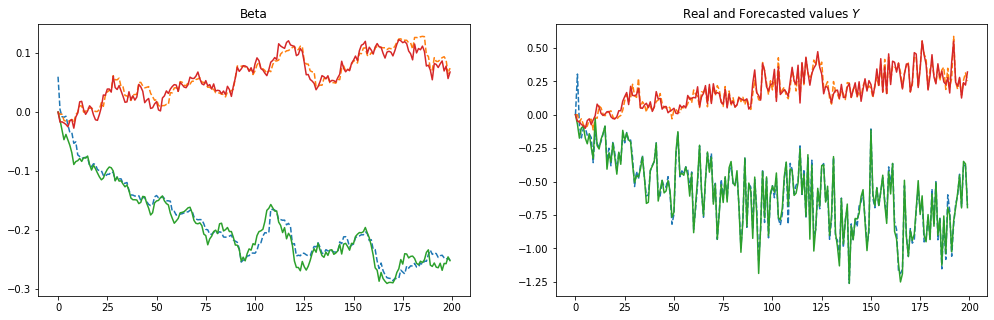

0.0016690105781261748
Mse error :0.0033380211562523496


<Figure size 432x288 with 0 Axes>

In [5]:
lag = False
time_dim = 200
n_dim = 2
for lag_length in [0]:
        K = n_dim + 1 if lag_length == 0 else (lag_length+1)*n_dim + 1
        print("Lag : " + str(lag_length))
        X,Y,Beta = run_DGP(periods=time_dim,dimensions=n_dim, lag = lag)
        sigma_bar, Q_0, beta_0 = get_priors(n_dim,K)
        print("Done with data")
        start = timee.time()
        x = get_x(time_dim,lag_length,K, Y, X, n_dim)
        print("In tvp da algo")
        beta, y_hat = tvp_da(sigma_bar, Q_0, beta_0, x, Y, time_dim, K, n_dim)
        end = timee.time()
        print('runtime for lag ' + str(lag_length) + ' :',end - start)
        plot(time_dim,n_dim,beta,Beta,y_hat,Y)
        lag = True
        print("Mse error :" + str(mse_error(y_hat,Y)))
        

0.00643919